# Теория вероятностей. Домашнее задание 1

В этом домашнем задании мы построим собственный алгоритм классификации на основе вероятностой модели.

В файле `languages.zip` вы найдете коллекцию текстов на английском, итальянском, испанском, немецком, французском, польском и португальском языках, полученных из случайных статей Википедии. См., например, файл `Spanish.txt`. (В соответствующих файлах `*.sources.txt` указаны источники со ссылками.)

In [14]:
%%capture
# загружаем данные
!wget https://github.com/MSBigDataAnalytics/datasets/raw/refs/heads/main/languages.zip

In [3]:
# проверяем загрузку (наличие файла languages.zip)
!ls -lah

total 2.1M
drwxr-xr-x 2 kvs users 4.0K Feb 23 14:10 .
drwxr-xr-x 9 kvs users 4.0K Feb 23 14:07 ..
-rw-r--r-- 1 kvs users 2.1M Feb 23 14:10 languages.zip
-rw-r--r-- 1 kvs users  49K Feb 23 14:10 probability_homework_01.ipynb


In [4]:
# разархивируем данные
!unzip languages.zip

Archive:  languages.zip
  inflating: English.sources.txt     
  inflating: English.txt             
  inflating: French.sources.txt      
  inflating: French.txt              
  inflating: German.sources.txt      
  inflating: German.txt              
  inflating: Italian.sources.txt     
  inflating: Italian.txt             
  inflating: Polish.sources.txt      
  inflating: Polish.txt              
  inflating: Portuguese.sources.txt  
  inflating: Portuguese.txt          
  inflating: Spanish.sources.txt     
  inflating: Spanish.txt             


In [1]:
with open("Spanish.txt") as f:
    print(f.read(500))

tomas zapata sierra medellin colombia  de mayo de  es productor de cine y de teatrocita requerida
sad eyed lady of the lowlands en espanol senorita de ojos tristes de las tierras bajas es una cancion compuesta por el cantante estadounidense bob dylan fue incluida en el album blonde on blonde editado el  de mayo de 
la revista mojo la coloco en el puesto  de su lista de las  mejores canciones de bob dylan
calyptocephalella canqueli es una especie extinta de anfibio anuro perteneciente al genero c


with open("German.txt") as f:
    print(f.read(500))
## Визуализация облака слов (0.5 баллов)

Выберите ваш любимый язык из предложенных и визуализируйте самые частые слова из приведенных текстов на этом языке в виде облака слов, используя `WordCloud` из библиотеки `wordcloud`.

In [7]:
import sys
!{sys.executable} -m pip install wordcount matplotlib wordcloud # Устанавливает пакет в ядро jupyter

  Using cached wordcloud-1.9.4-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (537 kB)


In [2]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

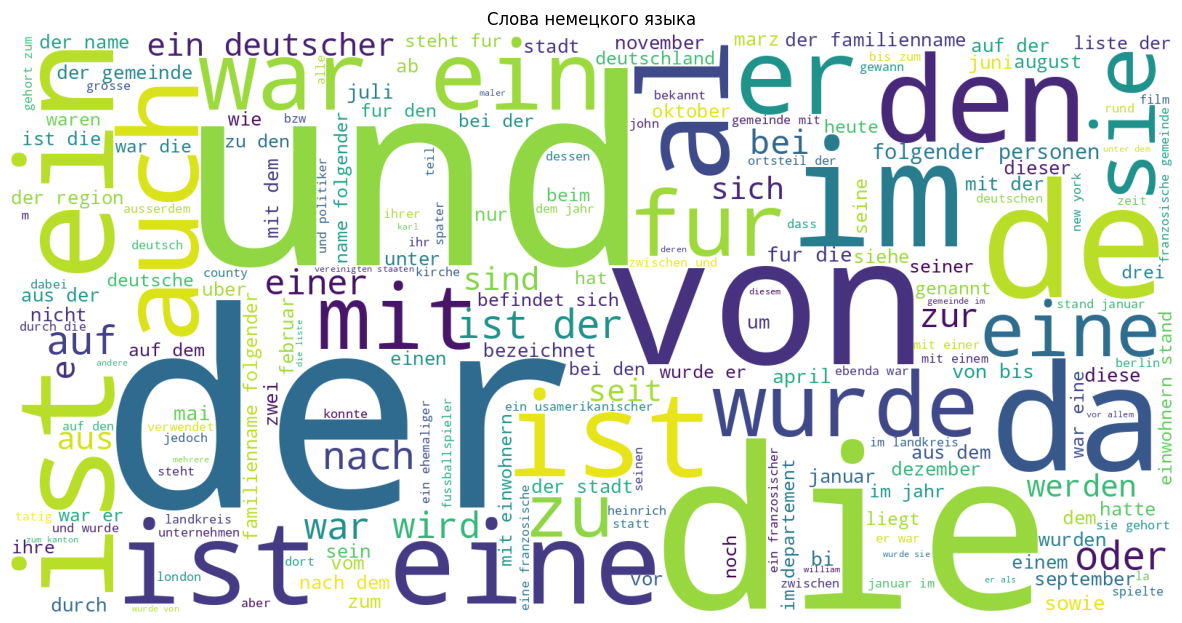

In [3]:
# Чтение текста из файла
with open("German.txt", "r") as f:
    text = f.read()

# Создание объекта
words = WordCloud(width=1600, height=800, background_color='white').generate(text)

# Визуализация объекта
plt.figure(figsize=(15, 10))
plt.imshow(words)
plt.axis('off')
plt.title('Слова немецкого языка')
plt.show()

## Предобработка данных

На данных из этих файлов мы будем обучать наш классификатор. Эти тексты уже предобработаны: оставлены только стандартные латинские символы, удалены диакритические знаки, убраны знаки препинания, все буквы преобразованы в нижний регистр.
Мы будем использовать аналогичную предварительную обработку для новых текстов, которые нам нужно классифицировать. Давайте посмотрим на некоторые полезные функции для этого.

In [4]:
import re
import unicodedata


def strip_accents(s):
    s = s.lower()
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def clean_text(s):
    return re.sub("[^a-z \n]", "", strip_accents(s))

Давайте проверим, что получится, если мы применим нашу функцию:

In [5]:
sample_text = "Café con leche!"
cleaned_text = clean_text(sample_text)
print(cleaned_text)

cafe con leche


In [6]:
sample_text2 = "Übung Nummer fünf"
cleaned_text2 = clean_text(sample_text2)
print(cleaned_text2)

ubung nummer funf


## Обучение: получение частот (1+1+1=3 балла)

Будем говорить, что абсолютная частота -- это то, сколько раз данный символ встречается в тексте, а относительная частота - это доля (то есть количество раз, сколько символ встречается в тексте, деленное на общее количество символов в тексте)
Прежде всего, нам нужно найти относительные частоты символов в текстах каждого языка. Мы будем рассматривать их в качестве вероятности появления символа в нашей мультиномиальной модели. Напишите функцию `get_freqs(text, relative)`, которая принимает строку `text` в качестве входных данных и возвращает словарь, где ключи — это все различные символы, встречающиеся в тексте, а значения — это частоты (относительные, если `relative` равно `True`, и абсолютные, если `relative` равно `False`).

Заметим, что мы будем использовать алфавит из 28 символов: 26 маленьких латинских букв, пробел и символ переноса строки `"\n"`. Это обусловлено тем, что пробел и символ переноса строки несут информацию о средней длине слова и средной длине текста.

In [89]:
def get_freqs(text, relative=False):
    ### НАЧАЛО РЕШЕНИЯ
    # Символы для анализа
    symbols = 'abcdefghijklmnopqrstuvwxyz \n'
    # Словарь хранения частот
    freqs = {}

    # Очистка текста от знаков препинания и удаление акцентов
    text_cl = clean_text(text)
    # Подсчёт количества каждого символа
    total_chars = 0
    for char in text_cl:
        if char in symbols:
            freqs[char] = freqs.get(char, 0) + 1
            total_chars += 1

    # Расчёт относительных частот
    if relative:
        for char in freqs:
            freqs[char] /= total_chars
    # print(freqs)
    return freqs

### КОНЕЦ РЕШЕНИЯ

In [8]:
# Проверка частот
get_freqs('Hello, World!', True)

{'h': 0.09090909090909091, 'e': 0.09090909090909091, 'l': 0.2727272727272727, 'o': 0.18181818181818182, ' ': 0.09090909090909091, 'w': 0.09090909090909091, 'r': 0.09090909090909091, 'd': 0.09090909090909091}


{'h': 0.09090909090909091,
 'e': 0.09090909090909091,
 'l': 0.2727272727272727,
 'o': 0.18181818181818182,
 ' ': 0.09090909090909091,
 'w': 0.09090909090909091,
 'r': 0.09090909090909091,
 'd': 0.09090909090909091}

In [9]:
# Проверка исходя из условий. Код предложенной проверки не отработал
assert get_freqs('Hello, World!') == {'h': 1, 'e': 1, 'l': 3, 'o': 2, ' ': 1, 'w': 1, 'r': 1, 'd': 1}

{'h': 1, 'e': 1, 'l': 3, 'o': 2, ' ': 1, 'w': 1, 'r': 1, 'd': 1}


In [10]:
# Почему предлагается использовать с верхним регистром и символами разделителя? Это же не будет работать)
assert get_freqs('Hello, World!') == {'H': 1, 'e': 1, 'l': 3, 'o': 2, ',': 1,
                                      ' ': 1, 'W': 1, 'r': 1, 'd': 1, '!': 1}

{'h': 1, 'e': 1, 'l': 3, 'o': 2, ' ': 1, 'w': 1, 'r': 1, 'd': 1}


AssertionError: 

Теперь используйте функцию `get_freqs`, чтобы создать словарь `lang_to_probs` с ключами - названиями языков (т.е. `'English'`, `'Italian'`, `'Spanish'`, `'German'`, `'French'`, `'Polish'`, `'Portuguese'`) и значениями - словарями относительных частот, полученных после обработки соответствующих `.txt` файлов.

In [12]:
### НАЧАЛО РЕШЕНИЯ
# Создание словаря
lang_to_probs = {}
# Языки
languages = ['English', 'Italian', 'Spanish', 'German', 'French', 'Polish', 'Portuguese']

for lang in languages:
    with open(f"{lang}.txt", "r") as f:
        text = f.read()
    lang_to_probs[lang] = get_freqs(clean_text(text), relative=True)

### КОНЕЦ РЕШЕНИЯ

{'a': 0.07760728328040059, 'l': 0.03626398545723105, 'e': 0.09363580376183861, 'x': 0.001387857977519179, 'i': 0.06683527488881646, ' ': 0.16778707284643476, 'r': 0.055831543781342974, 'y': 0.013557637617890481, 'o': 0.059573803685010765, 'm': 0.02255145297577816, 'n': 0.06324295321307709, '\n': 0.004925656661284587, 'v': 0.008451063755965, 'c': 0.028972774439621363, 'h': 0.036203266670714586, 'u': 0.021785652770325615, 's': 0.05419957149884944, 'k': 0.006603477823392594, 'b': 0.01411649828562365, 'f': 0.018519229887521547, 'd': 0.030964102805579683, 't': 0.06663700946345659, 'g': 0.01564190290198625, 'w': 0.012623311800882032, 'p': 0.01732591985863675, 'j': 0.0023073138876256354, 'z': 0.0016604729373890178, 'q': 0.0007881050658055339}
{'n': 0.06224587807925354, 'e': 0.0949648652747586, 'c': 0.0347429351397806, 'h': 0.008155372760296677, ' ': 0.15956870590104502, 'u': 0.027214065445196327, 't': 0.05812937378581178, 'r': 0.050755775744401196, 'o': 0.07134010269594922, 'a': 0.09609509847

In [13]:
assert abs(lang_to_probs['Polish']['a'] - 0.08504245058355897) < 0.00001
assert abs(lang_to_probs['English']['x'] - 0.001387857977519179) < 1e-5
assert len(set(lang_to_probs['Portuguese'])) == 28

Используя построенный словарь, визуализируйте для каждого языка долю каждой гласной среди всех гласных с помощью столбчатой диаграммы (_barplot_).

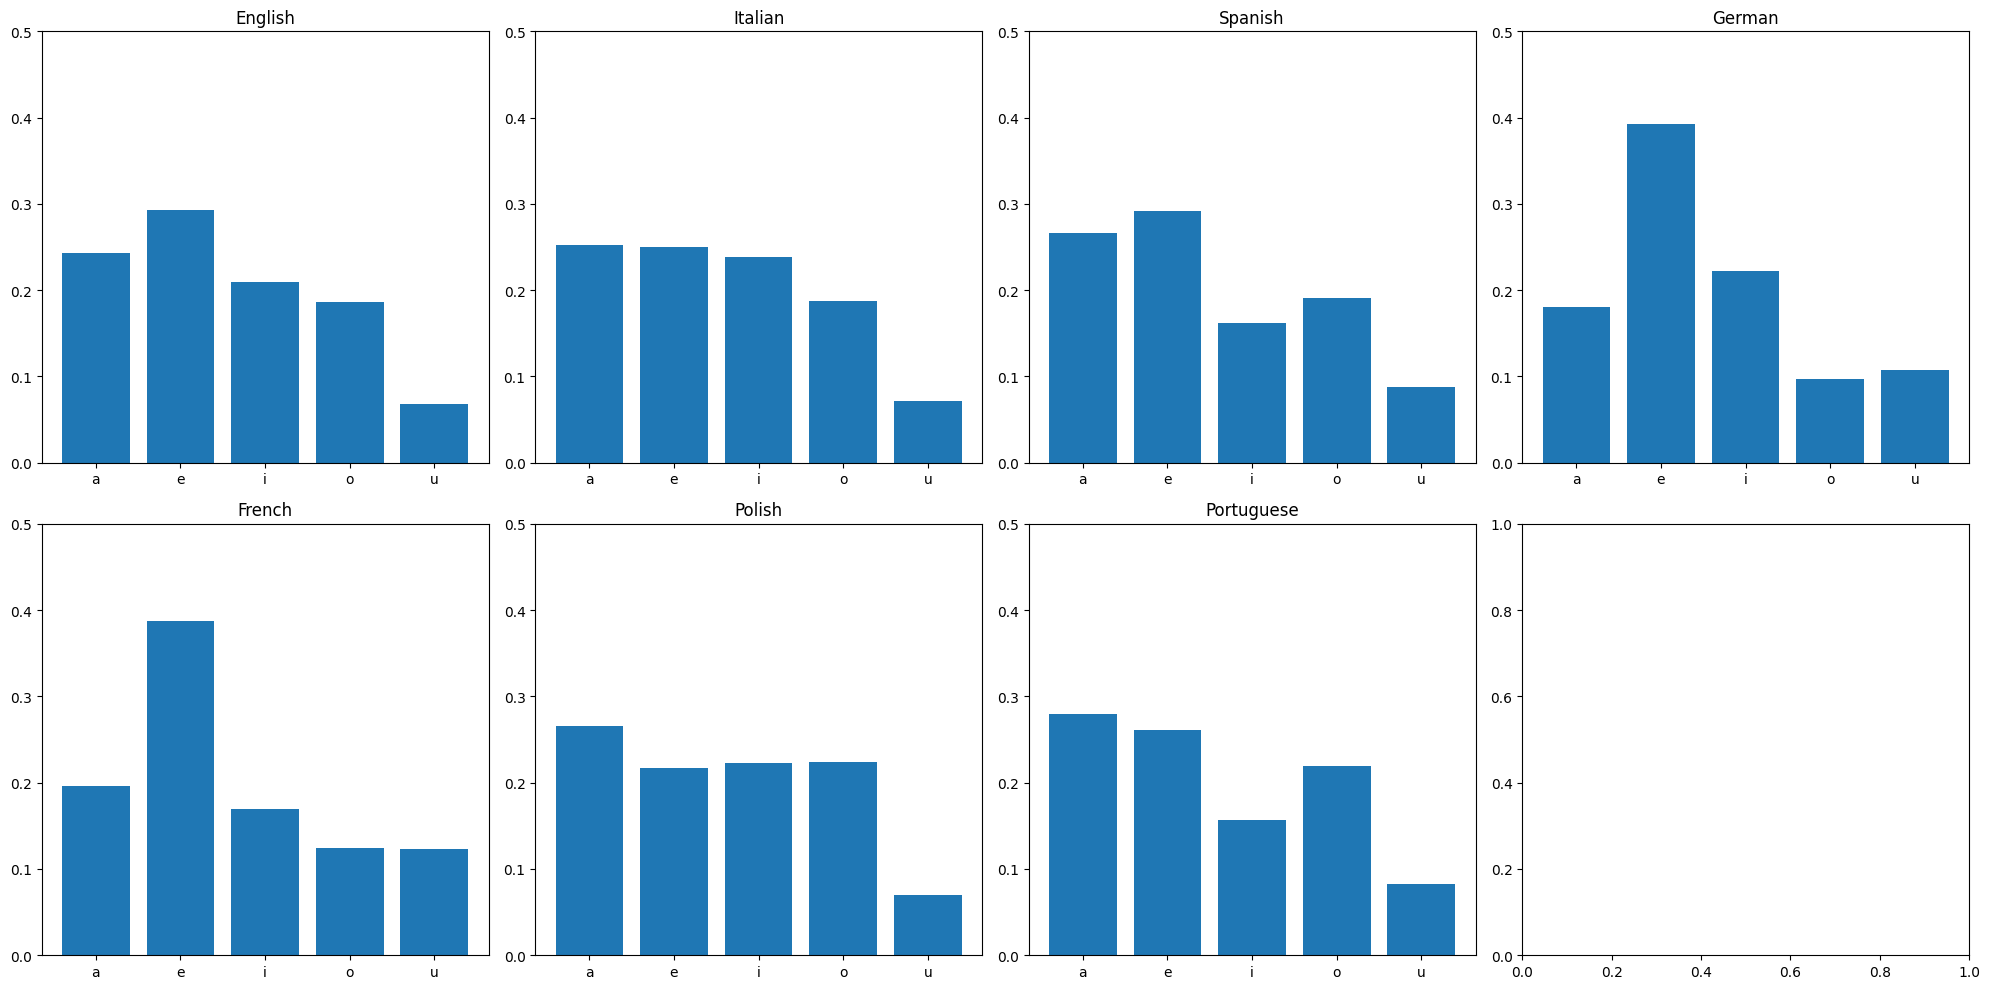

In [14]:
### НАЧАЛО РЕШЕНИЯ
# Визуализация доли гласных для каждого языка
import matplotlib.pyplot as plt

# Гласные
vowels = 'aeiou'
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for i, lang in enumerate(languages):
    vowel_freqs = {v: lang_to_probs[lang][v] for v in vowels}
    total_vowels = sum(vowel_freqs.values())
    vowel_ratios = {v: f / total_vowels for v, f in vowel_freqs.items()}

    axs[i].bar(vowel_ratios.keys(), vowel_ratios.values())
    axs[i].set_title(lang)
    axs[i].set_ylim(0, 0.5)

plt.tight_layout()
plt.show()
### КОНЕЦ РЕШЕНИЯ

## Правдоподобие (likelihood) (1+1=2 балла)


Давайте начнем имплементировать классификатор. Вначале недо написать мульиномиальную функцию правдоподобия. Напишите функцию `multinomial_likelihood(probs, freqs)`, которая принимает на вход два аргумента: `probs` - словарь вероятностей каждого символа (в некотором языке) и `freqs` - словарь абсолютных частот каждого символа (в некотором тексте, который мы хотим классифицировать). Эта функция должна возвращать вероятность получить такие абсолютные частоты из мультиномиального распределения - $P((X_1 = f_1) \cap (X_2 = f_2) \cap \ldots \cap (X_k = f_k))$, если $(X_1, \ldots, X_k)$ - система мультиномиальных случайных величин с вероятностями $(p_1, \ldots, p_k)$. (Вам понадобится функция `factorial`, которую можно импортировать из модуля `math`.)

In [15]:
from math import factorial

In [16]:
### НАЧАЛО РЕШЕНИЯ
def multinomial_likelihood(probs, freqs):
    # Вычисление общего количества наблюдений
    n = sum(freqs.values())

    # Вычисление коэффициента
    coeff = factorial(n)
    for f in freqs.values():
        coeff //= factorial(f)

    # Вычисление произведения вероятностей
    prob_product = 1
    for char, freq in freqs.items():
        prob_product *= probs[char] ** freq

    # Правдоподобие
    likelihood = coeff * prob_product
    # print(likelihood)

    return likelihood

### КОНЕЦ РЕШЕНИЯ

Давайте найдем вероятность получить следующий набор данных `{'a': 2, 'b': 1, 'c': 2}`из распределения `{'a': 0.2, 'b': 0.5, 'c': 0.3}`:

In [17]:
multinomial_likelihood(probs={'a': 0.2, 'b': 0.5, 'c': 0.3}, freqs={'a': 2, 'b': 1, 'c': 2})

0.05400000000000001

In [18]:
assert abs(multinomial_likelihood(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                  freqs={'a': 2, 'b': 1, 'c': 2}) - 0.054) < 0.000001
assert abs(multinomial_likelihood(probs={'a': 0.2, 'b': 0.1, 'c': 0.3, 'd': 0.4},
                                  freqs={'a': 2, 'b': 1, 'c': 2}) - 0.0108) < 0.000001

Заметим, что коэффициент с факториалами зависит только от `freqs` (т.е. только от анализируемого текста) и не зависит от вероятностей `probs`. Это означает, что для любого языка этот коэффициент будет одни и тем же. Так как мы будем рассматривать конкретный текст и сравнивать его правдоподобие для разных языков, нам в большинстве случаев будет не нужен этот коэффициент. Напишите функцию `multinomial_likelihood_without_coeff`, которая будет возвращать те же вероятности, что и `multinomial_likelihood`, но без этого коэффициента.

In [19]:
### НАЧАЛО РЕШЕНИЯ
def multinomial_likelihood_without_coeff(probs, freqs):
    prob_product = 1
    for char, freq in freqs.items():
        prob_product *= probs[char] ** freq
    # print(prob_product)
    return prob_product

### КОНЕЦ РЕШЕНИЯ

Результат новой функции меньше по сравнению с результатом `multinomial_likelihood`:

In [20]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                     freqs={'a': 2, 'b': 1, 'c': 2})

0.0018000000000000004

In [21]:
assert multinomial_likelihood_without_coeff(
    probs={'a': 0.3, 'b': 0.4, 'c': 0.3},
    freqs={'a': 2, 'b': 1, 'c': 2}) == 0.00324
assert abs(multinomial_likelihood_without_coeff(
    probs={'a': 0.3, 'b': 0.4, 'c': 0.3},
    freqs={'a': 2, 'b': 1, 'c': 5}) - 8.747999999999e-05) < 1e-10

На самом деле результат работы `multinomial_likelihood_without_coeff` становится очень маленьким слишком быстро, когда мы увеличиваем абсолютные частоты в наших данных. Это не удивительно: вероятность получить в результате случайного эксперимента текст, который совпадает с нашим, очень мала.

In [22]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                     freqs={'a': 3, 'b': 2, 'c': 2})

0.00018000000000000004

In [23]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                     freqs={'a': 3, 'b': 20, 'c': 2})

6.866455078125001e-10

Из-за ограничений в точности вычислений у компьютера, мы довольно быстро начнем получать в точности ноль.

In [24]:
multinomial_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                     freqs={'a': 543, 'b': 512, 'c': 2})

0.0

Таким образом, мы обычно не можем использовать правдоподобие напрямую. Обычный способ работы с такими маленькими числами — это использовать _логарифмы_ правдоводобия вместо самого правдоподобия. Действительно, логарифм — это монотонно возрастающая функция. Если мы сравниваем логарифмы, это эквивалентно сравнению их аргументов.



## Логарифм правдоподобия (log likelihood) (1 балл)


Напишите функцию `log_likelihood_without_coeff(probs, freqs)`, которая должна вычислять логарифмы правдоподобия (без коэффициента с факториалами). Заметим, что нельзя просто взять логарифм от результата `multinomial_likelihood_without_coeff`: если правдоподобие очень маленькое (равное нулю с точки зрения компьютера), логарифм от него будет минус бесконечностью. Поэтому нам придется вначале преобразовать логарифм правдоподобия. Воспользуйтесь следующими свойствами логарифма: $\log (ab) = \log a + \log b$, $\log (a^b)=b\log a$.

In [25]:
from math import log

In [26]:
### НАЧАЛО РЕШЕНИЯ
def log_likelihood_without_coeff(probs, freqs):
    log_likelihood = 0
    for char, freq in freqs.items():
        log_likelihood += freq * log(probs[char])
    # print(log_likelihood)

    return log_likelihood

### КОНЕЦ РЕШЕНИЯ

Правдоподобие - это вероятность, поэтому оно не больше 1 и логарифм от него неположительный. Чем больше абсолютное значение логарифма правдоподобия, тем меньше правдоподобие

In [27]:
log_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                             freqs={'a': 2, 'b': 1, 'c': 2})

-6.319968614080018

Теперь мы можем проводить вычисления для данных, которые раньше давали ноль из-за ограничений компьютерной точности.

In [28]:
log_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                             freqs={'a': 543, 'b': 512, 'c': 2})

-1231.2240885070605

In [29]:
assert abs(log_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                        freqs={'a': 2, 'b': 1, 'c': 2}) + 6.319968614080018) < 0.00001
assert abs(log_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                        freqs={'a': 543, 'b': 512, 'c': 2}) + 1231.2240885070605) < 0.0001
assert abs(log_likelihood_without_coeff(probs={'a': 0.2, 'b': 0.5, 'c': 0.3},
                                        freqs={'a': 543, 'b': 512}) + 1228.8161428984085) < 0.0001

## Бонус: кросс-энтропия и неравенство Йенсена (2 балла)

Полученная вами функция также известна как кросс-энтропия (cross entropy) и является чрезвычайно популярной в машинном обучении, особенно в задачах классификации. Она позволяет измерить, насколько хорошо распределение $(p_1, \ldots, p_k)$ (`probs`) соответствует фактическим абсолютным частотам $(f_1, \ldots, f_k)$ (`freqs`).

Предположим, что абсолютные частоты $(f_1, \ldots, f_k)$ зафиксированы. Тогда какое распределение $(p_1, \ldots, p_k)$ будет лучшим с точки зрения правдоподобия?

Интуитивно кажется, что нужно взять относительные частоты
$$r_i = \frac{f_i}{\sum_{j=1}^k f_j}$$
в качестве $p_i$, чтобы получить максимальное правдоподобие. Оказывается, что это так. Чтобы доказать это, давайте воспользуемся неравенством Йенсена для логарифмов. Оно формулируется следующим образом:

Для любых $\alpha_1, \ldots, \alpha_k$, таких что $\sum_{j=1}^k \alpha_j = 1$ и $\alpha_j \ge 0$ для всех $j=1, \ldots, k$, и любых положительных $x_1, \ldots, x_k$ выполняется следующее неравенство:

$$\log \sum_{j=1}^k \alpha_j x_j \ge \sum_{j=1}^k \alpha_j\log(x_j).$$

Используйте это неравенство, чтобы доказать, что
$$\sum_{j=1}^k r_j \log p_j - \sum_{j=1}^k r_j \log r_j \le 0,$$
затем докажите, что для получения максимального логарифма правдоподобия (а значит, и максимального правдоподобия) при фиксированных $(f_1, \ldots, f_k)$ нужно взять $p_i=r_i$, $i=1,\ldots, k$.

Решение можно написать либо ниже, используя _markdown_, либо написать там "Решение в файле ..." и загрузить файл вместе с ноутбуком.

### Приложил в фалике к заданию

## Максимальное правдоподобие (0,5 балла)

Теперь мы используем правдоподобие, чтобы найти наиболее подходящий язык для текста. Напишите функцию `mle_best(text, lang_to_probs)`, которая принимает на вход текст `text` и словарь `lang_to_prob`, который мы создали ранее, и возвращает название языка с максимальным правдоподобием получения такого текста. Заметим, что вам нужно обработать текст `text`, используя функцию `clean_text` перед нахождением абсолютных частот.

In [30]:
### НАЧАЛО РЕШЕНИЯ
def mle_best(text, lang_to_probs):
    # Очистка входного текста
    cleaned_text = clean_text(text)

    # Получение абсолютных частот символов в очищенном тексте
    freqs = get_freqs(cleaned_text, relative=False)

    # Инициализация переменных для отслеживания лучшего языка и его логарифма правдоподобия
    best_lang = None
    best_log_likelihood = float('-inf')

    # Итерация по каждому языку и вычисление логарифма правдоподобия
    for lang, probs in lang_to_probs.items():
        log_likelihood = log_likelihood_without_coeff(probs, freqs)

        # Обновление лучшего языка, если текущий логарифм правдоподобия выше
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_lang = lang
    # print(best_lang)
    return best_lang

### КОНЕЦ РЕШЕНИЯ

Давайте посмотрим, что она выдает!

In [31]:
# Source: https://en.wikipedia.org/wiki/1134_Kepler
text = """1134 Kepler, provisional designation 1929 SA, is a stony asteroid
and eccentric Mars-crosser from the asteroid belt, approximately
4 kilometers in diameter"""
mle_best(text, lang_to_probs)

{' ': 19, 'k': 2, 'e': 15, 'p': 4, 'l': 5, 'r': 12, 'o': 10, 'v': 1, 'i': 12, 's': 11, 'n': 7, 'a': 11, 'd': 5, 'g': 1, 't': 10, 'y': 2, '\n': 2, 'c': 4, 'm': 5, 'f': 1, 'h': 1, 'b': 1, 'x': 1}


'English'

In [32]:
# Source: https://pl.wikipedia.org/wiki/(1134)_Kepler
text = """"(1134) Kepler – planetoida z grupy przecinających
orbitę Marsa okrążająca Słońce w ciągu 4 lat i 145 dni
w średniej odległości 2,68 au.
"""
mle_best(text, lang_to_probs)

{' ': 20, 'k': 2, 'e': 9, 'p': 4, 'l': 4, 'r': 7, 'a': 13, 'n': 5, 't': 3, 'o': 6, 'i': 8, 'd': 4, 'z': 3, 'g': 3, 'u': 3, 'y': 2, 'c': 7, 'j': 3, 'h': 1, '\n': 3, 'b': 1, 'm': 1, 's': 4, 'w': 2}


'Polish'

In [33]:
# Source: https://it.wikipedia.org/wiki/1134_Kepler
text = """1134 Kepler è un asteroide areosecante. Scoperto nel 1929,
presenta un'orbita caratterizzata da un semiasse maggiore pari a 2,6829098
UA e da un'eccentricità di 0,4651458, inclinata di 15,17381° rispetto
"""
mle_best(text, lang_to_probs)

{' ': 26, 'k': 1, 'e': 20, 'p': 5, 'l': 3, 'r': 12, 'u': 5, 'n': 10, 'a': 19, 's': 8, 't': 13, 'o': 7, 'i': 13, 'd': 5, 'c': 7, '\n': 3, 'b': 1, 'z': 2, 'm': 2, 'g': 2}


'Italian'

In [34]:
lines = ['Aaa', 'Aa', 'Kepler è un asteroide areosecante. Scoperto nel',
         "presenta un'orbita caratterizzata da un semiasse maggiore pari a 2,6829098 "
         "UA e da un'eccentricità di 0,4651458, inclinata",
         "Kepler – planetoida z grupy przecinających orbitę Marsa okrążająca Słońce w ciągu 4 lat i ",
         "Kepler, provisional designation 1929 SA, is a stony asteroid "
         "and eccentric Mars-crosser from the"]
assert mle_best(lines[0], lang_to_probs) == 'Portuguese'
assert mle_best(lines[1], lang_to_probs) == 'Portuguese'
assert mle_best(lines[2], lang_to_probs) == 'French'
assert mle_best(lines[3], lang_to_probs) == 'Italian'
assert mle_best(lines[4], lang_to_probs) == 'Polish'
assert mle_best(lines[5], lang_to_probs) == 'English'
assert mle_best("Aaaa", lang_to_probs) == "Portuguese"

{'a': 3}
{'a': 2}
{'k': 1, 'e': 10, 'p': 2, 'l': 2, 'r': 4, ' ': 6, 'u': 1, 'n': 3, 'a': 3, 's': 3, 't': 3, 'o': 4, 'i': 1, 'd': 1, 'c': 2}
{'p': 2, 'r': 7, 'e': 9, 's': 4, 'n': 7, 't': 8, 'a': 16, ' ': 16, 'u': 4, 'o': 2, 'b': 1, 'i': 10, 'c': 5, 'z': 2, 'd': 3, 'm': 2, 'g': 2, 'l': 1}
{'k': 2, 'e': 6, 'p': 4, 'l': 3, 'r': 6, ' ': 15, 'a': 12, 'n': 3, 't': 3, 'o': 4, 'i': 5, 'd': 1, 'z': 3, 'g': 2, 'u': 2, 'y': 2, 'c': 6, 'j': 2, 'h': 1, 'b': 1, 'm': 1, 's': 2, 'w': 1}
{'k': 1, 'e': 8, 'p': 2, 'l': 2, 'r': 8, ' ': 13, 'o': 7, 'v': 1, 'i': 7, 's': 9, 'n': 6, 'a': 7, 'd': 3, 'g': 1, 't': 5, 'y': 1, 'c': 4, 'm': 2, 'f': 1, 'h': 1}
{'a': 4}


### Работает!
Отлично! Всего пара формул и мы получили алгоритм автоматического распознавания языка!

Давайте сделаем его еще лучше!

## Формула Байеса (1+1 = 2 балла)


Предположим, что мы случайным образом выбираем статью из всех статей Википедии на рассматриваемых нами языках. Количество статей на разных языках различается, поэтому вероятность получить статью, например, на английском языке выше, чем на польском (по крайней мере, на данный момент). Это означает, что для принятия гипотезы о том, что статья написана на польском языке, нам требуется более веское доказательство по сравнению с английским. Чтобы учесть эту информацию, мы воспользуемся правилом Байеса, как обсуждалось на лекции.

Напомним, что в байесовском подходе мы сначала рассматриваем априорные вероятности языков, затем используем правило Байеса, чтобы найти их апостериорные вероятности, и выбираем язык с наибольшей апостериорной вероятностью. Начнем с определения априорных вероятностей. Создайте словарь `lang_to_prior`, где ключами будут названия языков, а значениями — их априорные вероятности. Предположим, что априорные вероятности пропорциональны количеству статей на каждом языке (в тысячах). Используем следующие данные (в тысячах): English: 6090, Italian: 1611, Spanish: 1602, German: 2439, French: 2222, Polish: 1412, Portuguese: 1034. Помните, что сумма всех априорных вероятностей должна быть равна 1!

In [61]:
### НАЧАЛО РЕШЕНИЯ
# Статьи в разрезе языков
lang_to_article = {
    "English": 6090,
    "Italian": 1611,
    "Spanish": 1602,
    "German": 2439,
    "French": 2222,
    "Polish": 1412,
    "Portuguese": 1034
}

# Априорная вероятность в разрезе языков
lang_to_prior = {}

# Общее количество статей
total_articles = sum(lang_to_article.values())
print(total_articles)

#
for key, value in lang_to_article.items():
    lang_prob = value / total_articles
    # Заполнение априорная вероятности в разрезе языков
    lang_to_prior.setdefault(key, lang_prob)

print(lang_to_prior)
print(sum(lang_to_prior.values()))
### КОНЕЦ РЕШЕНИЯ

16410
{'English': 0.3711151736745887, 'Italian': 0.09817184643510055, 'Spanish': 0.09762340036563072, 'German': 0.1486288848263254, 'French': 0.13540524070688603, 'Polish': 0.08604509445460086, 'Portuguese': 0.06301035953686776}
1.0


In [60]:
assert sum(lang_to_prior.values()) == 1

In [51]:
assert abs(lang_to_prior['French'] - 0.13540524070688603) < 0.000001

Теперь напишите функцию `bayesian_best(text, lang_to_probs, lang_to_prior)`, которая принимает на вход текст `text`, словарь `lang_to_probs`, созданный ранее, и словарь `lang_to_prior` с априорными вероятностями. Эта функция должна возвращать название языка с наибольшей апостериорной вероятностью. Обратите внимание, что, так как мы только сравниваем апостериорные вероятности, мы можем игнорировать знаменатель в правиле Байеса: он одинаков для всех языков. Также учтите, что для избежания работы с чрезвычайно малыми числами необходимо использовать логарифмы апостериорных вероятностей вместо самих вероятностей. Используйте свойства логарифмов, чтобы сделать это эффективно.

In [55]:
lang_to_prior

{'English': 0.3711151736745887,
 'Italian': 0.09817184643510055,
 'Spanish': 0.09762340036563072,
 'German': 0.1486288848263254,
 'French': 0.13540524070688603,
 'Polish': 0.08604509445460086,
 'Portuguese': 0.06301035953686776}

In [54]:
lang_to_probs

{'English': {'a': 0.07760728328040059,
  'l': 0.03626398545723105,
  'e': 0.09363580376183861,
  'x': 0.001387857977519179,
  'i': 0.06683527488881646,
  ' ': 0.16778707284643476,
  'r': 0.055831543781342974,
  'y': 0.013557637617890481,
  'o': 0.059573803685010765,
  'm': 0.02255145297577816,
  'n': 0.06324295321307709,
  '\n': 0.004925656661284587,
  'v': 0.008451063755965,
  'c': 0.028972774439621363,
  'h': 0.036203266670714586,
  'u': 0.021785652770325615,
  's': 0.05419957149884944,
  'k': 0.006603477823392594,
  'b': 0.01411649828562365,
  'f': 0.018519229887521547,
  'd': 0.030964102805579683,
  't': 0.06663700946345659,
  'g': 0.01564190290198625,
  'w': 0.012623311800882032,
  'p': 0.01732591985863675,
  'j': 0.0023073138876256354,
  'z': 0.0016604729373890178,
  'q': 0.0007881050658055339},
 'Italian': {'n': 0.06224587807925354,
  'e': 0.0949648652747586,
  'c': 0.0347429351397806,
  'h': 0.008155372760296677,
  ' ': 0.15956870590104502,
  'u': 0.027214065445196327,
  't': 0

In [147]:
### НАЧАЛО РЕШЕНИЯ
def bayesian_best(text, lang_to_probs, lang_to_prior):
    # Очистка входного текста
    cleaned_text = clean_text(text)

    # Инициализация переменных для хранения лучшего языка и
    # максимального значения логарифма апостериорной вероятности
    best_lang = None
    max_log_posterior = -float('inf')

    for lang in lang_to_prior:
        # Логарифм априорной вероятности языка
        log_prior = log(lang_to_prior[lang])

        # Логарифм правдоподобия
        log_likelihood = 0
        for char in cleaned_text:
            if char in lang_to_probs[lang]:
                log_likelihood += log(lang_to_probs[lang][char])

        # Логарифм апостериорной вероятности
        log_posterior = log_likelihood + log_prior

        # Сравнение текущего значения логарифма
        # апостериорной вероятности с максимальным
        if log_posterior > max_log_posterior:
            max_log_posterior = log_posterior
            best_lang = lang

    return best_lang

### КОНЕЦ РЕШЕНИЯ

Метод максимального правдоподобия относит `"No problem"` к испанскому языку.  

In [148]:
mle_best("No problem", lang_to_probs)

'Spanish'

Однако, если мы учтем, что английский язык встречается более часто, язык будет распознан правильно.

In [149]:
bayesian_best("No problem", lang_to_probs, lang_to_prior)

'English'

In [150]:
lines = ['Aaa', 'Aa', 'Kepler è un asteroide areosecante. Scoperto nel',
         "presenta un'orbita caratterizzata da un semiasse maggiore pari a 2,6829098 "
         "UA e da un'eccentricità di 0,4651458, inclinata",
         "Kepler – planetoida z grupy przecinających orbitę Marsa okrążająca Słońce w ciągu 4 lat i ",
         "Kepler, provisional designation 1929 SA, is a stony asteroid "
         "and eccentric Mars-crosser from the"]
print(lines)
answers = ['English', 'English', 'French', 'Italian', 'Polish', 'English']
for line, answer in zip(lines, answers):
    assert bayesian_best(line, lang_to_probs, lang_to_prior) == answer

['Aaa', 'Aa', 'Kepler è un asteroide areosecante. Scoperto nel', "presenta un'orbita caratterizzata da un semiasse maggiore pari a 2,6829098 UA e da un'eccentricità di 0,4651458, inclinata", 'Kepler – planetoida z grupy przecinających orbitę Marsa okrążająca Słońce w ciągu 4 lat i ', 'Kepler, provisional designation 1929 SA, is a stony asteroid and eccentric Mars-crosser from the']


## Измеряем неопределенность (1 балл)


Наконец, давайте получим апостериорную вероятность, показывающую, насколько уверен наш байесовский алгоритм в своей классификации.
Реализуйте функцию `bayesian_posterior(text, lang_to_probs, lang_to_prior, test_lang)`, которая принимает на вход `text`, `lang_to_probs`, `lang_to_prior` и название языка `test_lang`, а возвращает апостериорную вероятность этого языка при условии такого текста. Используйте формулу с лекции.

Заметим, что теперь вам надо работать вероятностями, а не с их логарифмами.

In [170]:
### НАЧАЛО РЕШЕНИЯ
def bayesian_posterior(text, lang_to_probs, lang_to_prior, test_lang):
    # Формула для работы за основу:
    # P(lang∣text)= P(text∣lang)⋅P(lang) / P(text)

    # Очистка входного текста
    cleaned_text = clean_text(text)

    # Вычисление P(text | test_lang) * P(test_lang)
    likelihood = 1.0
    for char in cleaned_text:
        if char in lang_to_probs[test_lang]:
            likelihood *= lang_to_probs[test_lang][char]
        # else:
        #     # Если символа нет, то добавляется очень
        #     # маленькое значение, чтобы избежать нуля
        #     likelihood *= 1e-10

    # Определение числителя "P(text∣lang)⋅P(lang)"
    numerator = likelihood * lang_to_prior[test_lang]

    # Определение знаменателя P(text)
    # P(text) = sum(P(text | lang) * P(lang) для всех языков)
    denominator = 0.0
    for lang in lang_to_prior:
        likelihood_lang = 1.0
        for char in cleaned_text:
            if char in lang_to_probs[lang]:
                likelihood_lang *= lang_to_probs[lang][char]
            # else:
            #     likelihood_lang *= 1e-10  # Чтобы избежать нуля
        denominator += likelihood_lang * lang_to_prior[lang]

    # Вычисление апостериорной вероятности
    posterior = numerator / denominator

    return posterior

### КОНЕЦ РЕШЕНИЯ

In [171]:
bayesian_posterior("The", lang_to_probs, lang_to_prior, "German")

0.23835738730610442

In [172]:
bayesian_posterior("The", lang_to_probs, lang_to_prior, "English")

0.6022412845303765

In [173]:
bayesian_posterior("Das", lang_to_probs, lang_to_prior, "German")

0.1344632494818005

In [174]:
bayesian_posterior("Das", lang_to_probs, lang_to_prior, "English")

0.3121368698953276

In [175]:
assert abs(bayesian_posterior("The", lang_to_probs, lang_to_prior, "German") - 0.2383573) < 0.00001
assert abs(bayesian_posterior("The", lang_to_probs, lang_to_prior, "English") - 0.6022412) < 0.00001
assert abs(bayesian_posterior("Das", lang_to_probs, lang_to_prior, "German") - 0.1344632) < 0.00001
assert abs(bayesian_posterior("Das", lang_to_probs, lang_to_prior, "English") - 0.3121368) < 0.00001

Мы видим, что наш алгоритм считает, что `"Das"` относится к английскому языку. Это связано с небольшим количеством данных (всего три буквы!) и высоким априорным значением для английского. Однако алгоритм не очень уверен в этом: апостериорная вероятность составляет всего 0.37. С другой стороны, `"The"` относится к английскому языку с гораздо большей апостериорной вероятностью.

## Подведем итог


Сегодня мы использовали наши знания о вероятности, чтобы создать собственный алгоритм классификации. Фактически, это вариант известного наивного байесовского классификатора. Конечно, этот классификатор далёк от совершенства: например, он полностью игнорирует слова и работает только с отдельными символами и их частотами. Тем не менее, несмотря на свою простоту, он показывает довольно хорошие результаты.

Кроме того, он иллюстрирует несколько важных концепций: правдоподобие, оценку максимального правдоподобия, байесовские оценки и многое другое.

Теперь вы готовы к более сложным темам!